In [37]:
import MeCab
import pandas as pd
import glob
import os
import fastText
import numpy as np
import time
import re
import neologdn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

### load livedoor data

In [3]:
dirlist = [
    "dokujo-tsushin",
    "it-life-hack",
    "kaden-channel",
    "livedoor-homme",
    "movie-enter",
    "peachy",
    "smax",
    "sports-watch",
    "topic-news"
]

In [3]:
df = pd.DataFrame(columns=["class", "news"])
for item in dirlist:
    path = "datasets/ldcc/" + item + "/*.txt"
    files = glob.glob(path)
    for file in files:
        with open(file) as f:
            data = f.read()
        t = pd.Series([item,"".join(data.split("\n")[3:])],index = df.columns)
        df  = df.append(t,ignore_index=True)

In [4]:
df.head()

,class,news
0,dokujo-tsushin,タニタだけじゃない。2008年から社員食堂を一般公開しているのはロート製薬が運営する旬穀旬菜...
1,dokujo-tsushin,東京・渋谷のセンター街でマスク姿の10〜30代の男女100人にアンケート調査を実施したところ...
2,dokujo-tsushin,あなたは親友と呼べる友達がいるだろうか？ 独女たちの間ではよくある話だが、親友が結婚した途端...
3,dokujo-tsushin,互いに好意を持ちながらも、天井裏から覗く、覗かれるという関係しか築けない複雑な男女の愛を、近...
4,dokujo-tsushin,「女性ホルモンで美しく！」なんてよく聞くけれど、それがどんなものか、みんなはイメージできるか...


### 文書の整形とわかち書き

In [5]:
# 日本語stopwordsのリスト
stop_words = [];
with open('datasets/Japanese_stopwords.txt', 'r') as f:
    for line in f:
        stop_words.append(line.replace('\n', ''))

In [6]:
def clean_text(text):
#     空白、改行、スペース除去
    text = text.rstrip()
    
#     アルファベットの小文字化
    text = text.lower()
    
#     半角、全角変換など
    text = neologdn.normalize(text, repeat=4)
    
    #連続した数字を0で置換
    text = re.sub(r'\d+', '0', text)
    
    #特殊文字削除
    text = re.sub(r'[！＠＃＄％＾＆\-|\\＊\“（）＿■×※⇒—●(：〜＋=)／*&^%$#@!~`){}…\[\]\"\'\”:;<>?＜＞？、。・,./『』【】「」→←○]+', "", text)
    
    return text

In [7]:
def get_surfaces(text):
    text = clean_text(text)
    
    tagger = MeCab.Tagger('/opt/modules/mecab-ipadic-neologd/build/mecab-ipadic-2.7.0-20070801-neologd-20180903')
    tagger.parse('')
    node = tagger.parseToNode(text)
    surf = []
    while node:
#         if node.feature.split(',')[0] in ['名詞', '動詞'] \
#         and node.surface not in stop_words \
#         and len(node.surface) >= 2:
#             surf.append(node.surface)
        surf.append(node.surface)
        node = node.next
    return ' '.join(surf)

In [8]:
df['wakati_news'] = pd.Series(
    np.vectorize(get_surfaces)(df['news']), index=df.index)

In [22]:
df.head()

,class,news,wakati_news
0,dokujo-tsushin,タニタだけじゃない。2008年から社員食堂を一般公開しているのはロート製薬が運営する旬穀旬菜...,タニタ だけ じゃ ない 0 年 から 社員食堂 を 一般 公開 し て いる の は ロ...
1,dokujo-tsushin,東京・渋谷のセンター街でマスク姿の10〜30代の男女100人にアンケート調査を実施したところ...,東京渋谷 の センター街 で マスク 姿 の 0 代 の 男女 0 人 に アンケート 調...
2,dokujo-tsushin,あなたは親友と呼べる友達がいるだろうか？ 独女たちの間ではよくある話だが、親友が結婚した途端...,あなた は 親友 と 呼べる 友達 が いる だろ う か 独女 たち の 間 で は よ...
3,dokujo-tsushin,互いに好意を持ちながらも、天井裏から覗く、覗かれるという関係しか築けない複雑な男女の愛を、近...,互いに 好意 を 持ち ながら も 天井 裏 から 覗く 覗か れる という 関係 しか ...
4,dokujo-tsushin,「女性ホルモンで美しく！」なんてよく聞くけれど、それがどんなものか、みんなはイメージできるか...,女性ホルモン で 美しく なんて よく 聞く けれど それ が どんな もの か みんな ...


In [10]:
df.to_csv('datasets/ldcc.csv')

NameError: name 'df' is not defined

### 予め作成したcsvをロード

In [11]:
df = pd.read_csv('datasets/ldcc.csv', index_col=0)

### fasttextでクラス分類

In [6]:
x_train, x_test, y_train, y_test = train_test_split(df['wakati_news'], 
                                                    df['class'], 
                                                    test_size=0.1, 
                                                    random_state=0, 
                                                    shuffle=True)

In [32]:
classToClassid = {
    'dokujo-tsushin' : 0,
    'it-life-hack' : 1,
    'kaden-channel' : 2,
    'livedoor-homme' : 3,
    'movie-enter' : 4,
    'peachy' : 5,
    'smax' : 6,
    'sports-watch' : 7,
    'topic-news' : 8
}

In [ ]:
# fasttextでtrain用のファイルを作成
with open('train.txt', 'w') as train_file:
    for x, y in zip(x_train, y_train):
        output_text = '__label__%d, ' % (classToClassid[y])
        output_text += x
        output_text += '\n'
        train_file.write(output_text)

In [94]:
ft_clf_model = fastText.train_supervised('train.txt',
                                     dim = 100,
                                     ws = 3,
                                     label='__label__')

In [103]:
ft_clf_model.save_model('model.bin')

In [131]:
pred = [int(ft_clf_model.predict(text)[0][0][9]) for text in x_test]

In [135]:
ans = [classToClassid[item] for item in y_test.values]

In [136]:
accuracy_score(ans, pred)

0.3902439024390244

### fasttextで分散表現のみを得る

In [ ]:
with open('train_unsupervised.txt', 'w') as train_file:
    for item in df.wakati_news.values:
        train_file.write(item)
        train_file.write('\n')

In [ ]:
ft_model = fastText.train_unsupervised('train_unsupervised.txt',
                            ws=3,
                            model='skipgram',
                            verbose=0)

In [ ]:
ft_model.save_model('ldcc_unsupervised.bin')

In [4]:
ft_model = fastText.load_model('ldcc_unsupervised.bin')

In [9]:
ft_model.get_word_vector('人')

array([ 0.22329487,  0.5441234 ,  0.24677876, -0.01529679,  0.0045419 ,
        0.1674589 , -0.20387904,  0.07550597,  0.4501384 ,  0.05792811,
       -0.17710587, -0.13196936,  0.0280139 , -0.30896825,  0.4360414 ,
        0.07068592,  0.04861223, -0.11567722, -0.18947953,  0.14265385,
        0.40753904,  0.08458737,  0.15458877, -0.07445165, -0.01654267,
       -0.07439252,  0.06423857, -0.34171134, -0.35630772,  0.10236371,
       -0.0760482 ,  0.1876666 ,  0.10409233, -0.36525553, -0.37157795,
       -0.26561275, -0.2203008 ,  0.17371863, -0.20260039,  0.14867909,
       -0.56622374,  0.16040176,  0.09372009, -0.31280008,  0.00168025,
        0.11225977,  0.24297863,  0.2651376 ,  0.05673487, -0.11028023,
       -0.2610187 , -0.19193973,  0.17962673,  0.35254455, -0.47769442,
       -0.35410234, -0.10585123,  0.45987323,  0.09243552, -0.15810865,
        0.08114442,  0.34720495,  0.18225119, -0.01465374, -0.02438155,
        0.05931043, -0.08746625,  0.23701647,  0.01445285,  0.41

### tsneを書いてみる

In [14]:
vectors = [ft_model.get_sentence_vector(item) for item in df.wakati_news.values]

In [16]:
embedded = TSNE(n_components=2, verbose=0, random_state=0).fit_transform(vectors)

In [18]:
embedded.

array([[-18.384188,  34.59402 ],
       [-52.855755,  20.671114],
       [-61.03665 ,   6.855818],
       ...,
       [-16.608744, -24.632723],
       [-15.112492, -53.63746 ],
       [-21.21894 , -29.512869]], dtype=float32)

In [20]:
with open('tsne.pickle', mode='wb') as f:
    pickle.dump(embedded, f)

In [23]:
with open('tsne.pickle', mode='rb') as f:
    embedded = pickle.load(f)

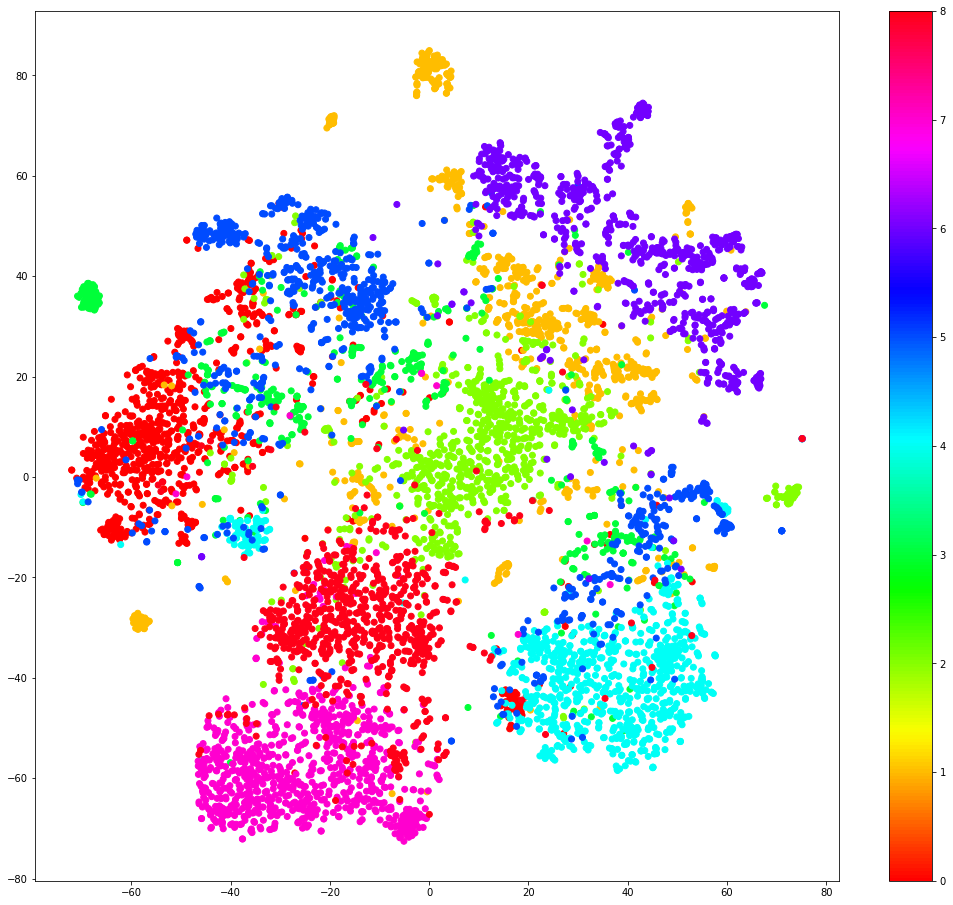

In [42]:
ys_labels = [classToClassid[item] for item in df['class'].values]
plt.figure(figsize=(18, 16))
plt.scatter(embedded[:, 0], embedded[:, 1], c=ys_labels, cmap='hsv')
plt.colorbar()

In [45]:
def plot_data(data, labels, classes):
    plt.figure(figsize=(18,16))
    plt.scatter(data[:,0], data[:,1], c=["w" for _ in labels])
    for d, l in zip(data,labels):
        plt.text(d[0], d[1], str(l), fontdict={"size":12, "color":cm.hsv(l/ len(classes))})

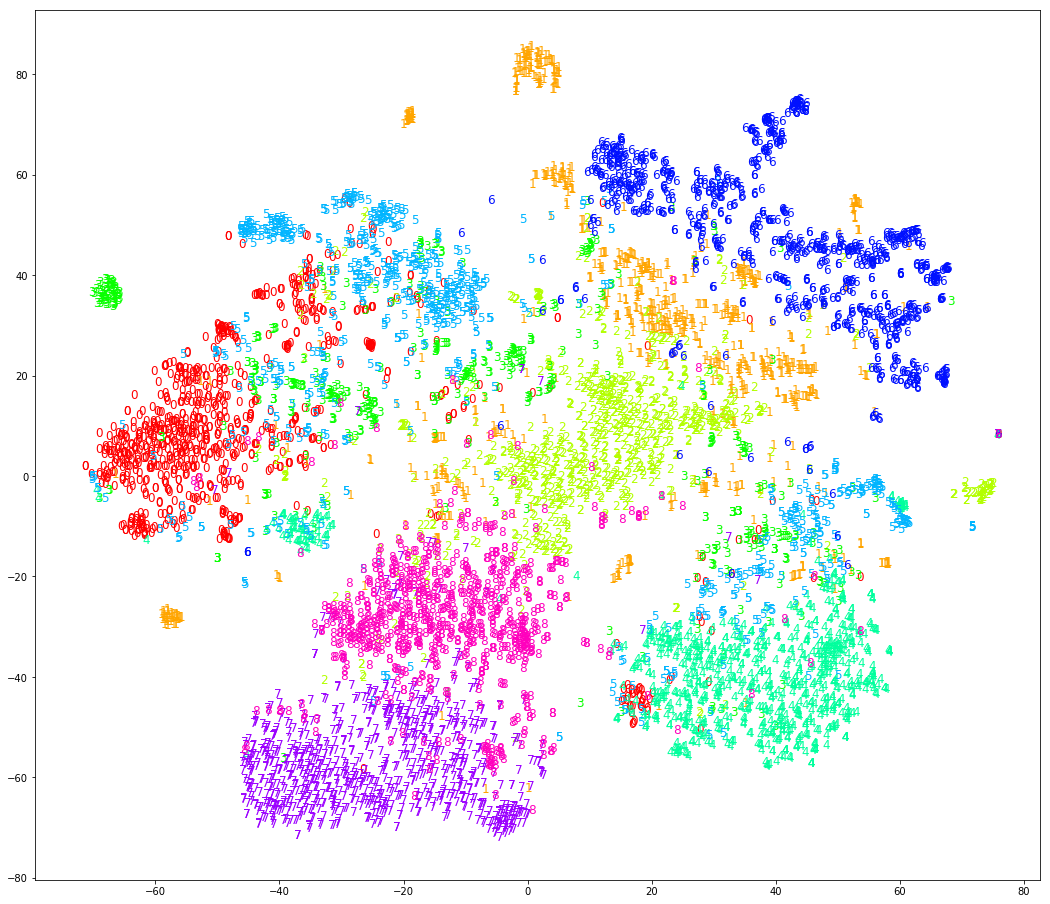

In [46]:
plot_data(embedded, ys_labels, list(range(9)))